In [1]:
import gym
env = gym.make("Taxi-v3").env

In [13]:
import numpy as np

class QAgent:

    def __init__(self, env, alpha, gamma):
        
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        # hyper-parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor

    def get_action(self, state):
        
        """"""
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        
        """"""
        # Q-learning formula
        old_value = self.q_table[state, action]

        next_max = np.max(self.q_table[next_state])

        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        
        self.q_table[state, action] = new_value


In [4]:
# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.

alpha = 0.1 # learning rate
gamma = 0.6 # discount factor
epsilon = 0.1 # exploration vs exploitation prob

agent = QAgent(env.env, alpha, gamma)

Its API is the same as for the RandomAgent above, but with an extra method `update_parameters()` . This method takes the transition vector `(state, action, reward, next_state)` and updates the q-value matrix approximation `self.q_table` using the Q-learning formula from above.

Now, we need to plug this agent into a training loop and call its `update_parameters()` method every time the agent collects a new experience.

Also, remember we need to guarantee the agent explores enough the state space. Remember the exploration-exploitation parameter we talked about in part 1? This is when the epsilon parameter enters into the game.

Let’s train the agent for `n_episodes = 10,000` and use `epsilon = 10%`

### Q LEARNING TRAINING LOOP

In [5]:
import random
from tqdm import tqdm

n_episodes = 10000

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action) 
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 10000/10000 [00:18<00:00, 546.30it/s]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


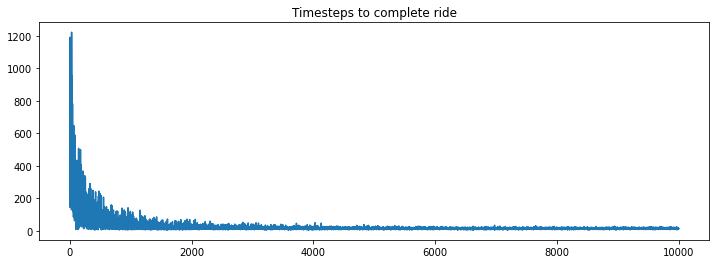

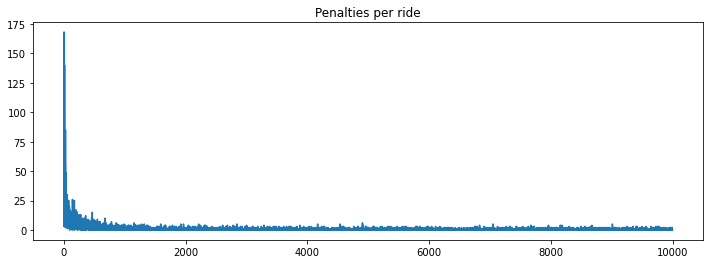

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

Nice! These graphs look much much better than for the RandomAgent. Both metrics decrease with training, which means our agent is learning 🎉🎉🎉.

We can actually see how the agent drives starting from the `same state = 123` as we used for the RandomAgent.

In [8]:
# set initial state of the environment
state = 123
env.env.s = state

epochs = 0
penalties = 0
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    next_state, reward, done, info = env.step(action)
    agent.update_parameters(state, action, reward, next_state)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    state = next_state

    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 11
Penalties incurred: 0


In [9]:
# view how our trained Q learning agent did

from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        sleep(0.2)
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.3)

print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 479
Action: 5
Reward: 20


When you evaluate the agent, it is still good practice to use a positive epsilon value, and not `epsilon = 0`.

Why so? Isn’t our agent fully trained? Why do we need to keep this source of randomness when we choose the next action?

The reason is to prevent overfitting. Even for such a small state, action space in Taxi-v3(i.e. 500 x 6) it is likely that during training our agent has not visited enough certain states.

Hence, its performance in these states might not be 100% optimal, causing the agent to get “caught” in an almost infinite loop of suboptimal actions.

If epsilon is a small positive number (e.g. 5%) we can help the agent escape these infinite loops of suboptimal actions.

By using a small epsilon at evaluation we are adopting a so-called epsilon-greedy strategy.

Let’s evaluate our trained agent on `n_episodes = 100` using `epsilon = 0.05`. Observe how the loop looks almost exactly as the train loop above, but without the call to `update_parameters()`

In [10]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.05

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()      
    
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action)
        
        agent.update_parameters(state, action, reward, next_state)
                      
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
            
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:00<00:00, 1125.62it/s]


In [11]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

Avg steps to complete ride: 13.64
Avg penalties to complete ride: 0.15
